In [1]:
from transformers import ViTFeatureExtractor, TFViTMAEForPreTraining
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
from PIL import Image

c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tf.config.list_physical_devices('GPU')

tf.keras.backend.clear_session()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
classification_train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/train",
    image_size=(224,224),
    batch_size=64,
    label_mode="int",
    color_mode="rgb",
    shuffle=True
).map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).prefetch(tf.data.AUTOTUNE)

classification_val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/val",
    image_size=(224,224),
    batch_size=64,
    label_mode="int",
    color_mode="rgb",
    shuffle=False
).map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).prefetch(tf.data.AUTOTUNE)

classification_test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/test",
    image_size=(224,224),
    batch_size=64,
    label_mode="int",
    color_mode="rgb",
    shuffle=False
).map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).prefetch(tf.data.AUTOTUNE)

feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/vit-mae-base")

def preprocess_batch(images, labels):
    def _preprocess(images_np):
        # De [0,1] a [0,255] y a uint8
        images_np = (images_np * 255.0).astype(np.uint8)
        # Preprocesa todo el batch
        processed = feature_extractor(images=list(images_np), return_tensors="np")
        # Retorna (batch_size, 3, 224, 224)
        return processed["pixel_values"].astype(np.float32)

    images = tf.numpy_function(_preprocess, [images], tf.float32)
    images.set_shape([None, 3, 224, 224])  # None = batch size variable
    return images, labels

final_train_dataset = classification_train_dataset.map(
    preprocess_batch,
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)


final_test_dataset = classification_test_dataset.map(
    preprocess_batch,
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

final_val_dataset = classification_val_dataset.map(
    preprocess_batch,
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

Found 20300 files belonging to 29 classes.
Found 2900 files belonging to 29 classes.
Found 5800 files belonging to 29 classes.


c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:

# 1️⃣ Carga el modelo ViT-MAE preentrenado (solo queremos el encoder)
mae_model = TFViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
vit_encoder = mae_model.vit

# 2️⃣ Congela el encoder (opcional: lo puedes descongelar más adelante para fine-tuning)
vit_encoder.trainable = False

# 3️⃣ Define el modelo Keras
inputs = keras.Input(shape=(3, 224, 224))
x = vit_encoder(pixel_values=inputs, training=False)[0]  # [0]: el output del encoder
# Extrae el token CLS (el primer token de la secuencia)
cls_token_output = x[:, 0, :]

# --- INICIO DE LA NUEVA CABEZA ROBUSTA Y REGULARIZADA ---

# Capa de normalización inicial para estabilizar la entrada al head
x = layers.LayerNormalization()(cls_token_output)

# Primera capa Dense con regularización L2 y Batch Normalization
x = layers.Dense(1024,activation='relu',kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x) # Normalización de lotes para estabilidad
x = layers.Dropout(0.3)(x) # Dropout para regularización

# Segunda capa Dense con regularización L2 y Batch Normalization
x = layers.Dense(512,activation='relu',kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x) # Normalización de lotes para estabilidad
x = layers.Dropout(0.3)(x) # Dropout para regularización


outputs = layers.Dense(29, activation='softmax')(x)  # 30 clases

model = keras.Model(inputs, outputs)

# 4️⃣ Compila el modelo

model.summary()

All PyTorch model weights were used when initializing TFViTMAEForPreTraining.

All the weights of TFViTMAEForPreTraining were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTMAEForPreTraining for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 224, 224)]     0         
                                                                 
 vit (TFViTMAEMainLayer)     TFViTMAEModelOutput(last  85798656  
                             _hidden_state=(None, 50,            
                              768),                              
                              mask=(None, 196),                  
                              ids_restore=(None, 196)            
                             , hidden_states=None, at            
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                                 
                                                             

In [7]:
for images, labels in final_train_dataset.take(1):
    print("Shape de las imágenes en el batch:", images.shape)
    print("Shape de las etiquetas:", labels.shape)

Shape de las imágenes en el batch: (64, 3, 224, 224)
Shape de las etiquetas: (64,)


In [5]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5 , restore_best_weights=True, verbose=1),
    keras.callbacks.ModelCheckpoint(filepath='best_modelV5.h5', save_best_only=True, monitor='val_loss'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', verbose=1, factor=0.2, min_lr=1e-6),
]

history = model.fit(
    final_train_dataset,
    validation_data=final_test_dataset,
    epochs=100,
    callbacks=callbacks,
    verbose=1

)
#save
model.save("best_modelV5.h5")
model.save_weights("best_modelV5_weights.h5")

Epoch 1/100
318/318 [==============================] - 88s 218ms/step - loss: 3.9269 - accuracy: 0.3262 - val_loss: 2.8468 - val_accuracy: 0.5771 - lr: 1.0000e-04
Epoch 2/100
318/318 [==============================] - 55s 169ms/step - loss: 2.8230 - accuracy: 0.5405 - val_loss: 2.2495 - val_accuracy: 0.6967 - lr: 1.0000e-04
Epoch 3/100
318/318 [==============================] - 55s 170ms/step - loss: 2.5053 - accuracy: 0.6091 - val_loss: 2.0650 - val_accuracy: 0.7331 - lr: 1.0000e-04
Epoch 4/100
318/318 [==============================] - 54s 169ms/step - loss: 2.3084 - accuracy: 0.6529 - val_loss: 1.9834 - val_accuracy: 0.7478 - lr: 1.0000e-04
Epoch 5/100
318/318 [==============================] - 58s 179ms/step - loss: 2.1780 - accuracy: 0.6819 - val_loss: 1.8665 - val_accuracy: 0.7724 - lr: 1.0000e-04
Epoch 6/100
318/318 [==============================] - 66s 202ms/step - loss: 2.0796 - accuracy: 0.7002 - val_loss: 1.8265 - val_accuracy: 0.7740 - lr: 1.0000e-04
Epoch 7/100
318/318 [=

<Figure size 1200x1200 with 0 Axes>

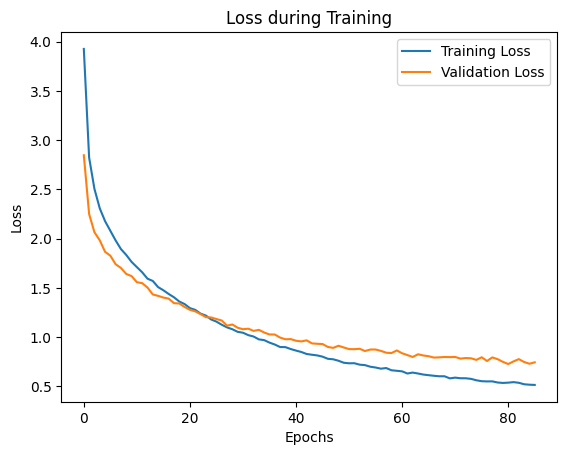

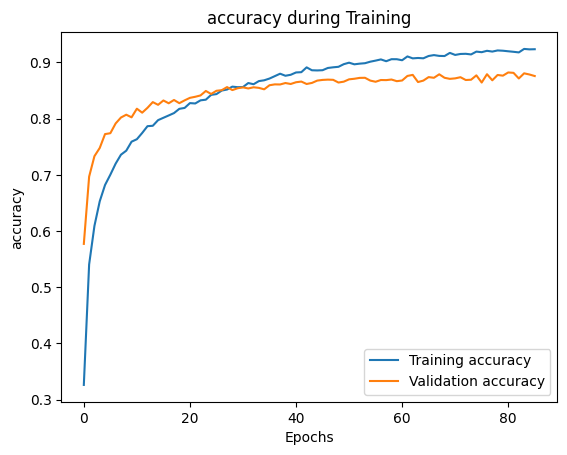

In [6]:
import matplotlib.pyplot as plt
def plot_training_history(history):
    plt.figure(figsize=(12, 12))
    
    # Pérdida
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss during Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('accuracy during Training')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()


# Llamar a la función para graficar el progreso del entrenamiento
plot_training_history(history)

In [30]:
import collections

# Analizar el número de clases en final_val_dataset

class_counts = collections.Counter()

for _, labels in final_train_dataset:
    class_counts.update(labels.numpy())

num_classes = len(class_counts)
print(f"Número de clases: {num_classes}")
print("Distribución de clases:")
for class_label, count in class_counts.items():
    print(f"Clase {class_label}: {count} muestras")

Número de clases: 29
Distribución de clases:
Clase 16: 700 muestras
Clase 14: 700 muestras
Clase 21: 700 muestras
Clase 26: 700 muestras
Clase 28: 700 muestras
Clase 18: 700 muestras
Clase 9: 700 muestras
Clase 27: 700 muestras
Clase 7: 700 muestras
Clase 3: 700 muestras
Clase 23: 700 muestras
Clase 4: 700 muestras
Clase 0: 700 muestras
Clase 1: 700 muestras
Clase 17: 700 muestras
Clase 5: 700 muestras
Clase 25: 700 muestras
Clase 11: 700 muestras
Clase 22: 700 muestras
Clase 15: 700 muestras
Clase 6: 700 muestras
Clase 13: 700 muestras
Clase 10: 700 muestras
Clase 24: 700 muestras
Clase 19: 700 muestras
Clase 8: 700 muestras
Clase 2: 700 muestras
Clase 12: 700 muestras
Clase 20: 700 muestras


In [14]:
model.save_weights("best_modelV5_weights.h5")

In [6]:
import numpy as np
import os

import matplotlib.pyplot as plt
mae_model = TFViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
vit_encoder = mae_model.vit
vit_encoder.trainable = False # Asegurarse de que esté congelado, igual que durante el entrenamiento

# Reconstruir la arquitectura del modelo Keras (tu cabezal de clasificación)
inputs = keras.Input(shape=(3, 224, 224))
x = vit_encoder(pixel_values=inputs, training=False)[0]
cls_token_output = x[:, 0, :] # Tomar el token CLS

# Cabezal de clasificación (asegúrate de que sea idéntico al que entrenaste)
x = layers.LayerNormalization()(cls_token_output)
x = layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(29, activation='softmax')(x) # 29 clases según tu notebook

model_for_inference = keras.Model(inputs, outputs)

# (Opcional) Compila el modelo. No es estrictamente necesario para `predict`, pero si quieres `evaluate` sí.
model_for_inference.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- 3. CARGA DE PESOS ---
weights_path = "best_modelV5_weights.h5"
if os.path.exists(weights_path):
    try:
        model_for_inference.load_weights(weights_path)
        print("¡Pesos del modelo cargados exitosamente para inferencia!")
    except Exception as e:
        print(f"Error al cargar los pesos: {e}")
        print("Asegúrate de que la arquitectura del modelo sea idéntica a la que guardó los pesos.")
else:
    print(f"Error: No se encontró el archivo de pesos en '{weights_path}'.")
    print("Asegúrate de que el archivo 'best_modelV5_weights.h5' esté en el mismo directorio o especifica la ruta completa.")

All PyTorch model weights were used when initializing TFViTMAEForPreTraining.

All the weights of TFViTMAEForPreTraining were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTMAEForPreTraining for predictions without further training.


¡Pesos del modelo cargados exitosamente para inferencia!


1/1 [==============================] - 3s 3s/step
Accuracy de validación: 0.89


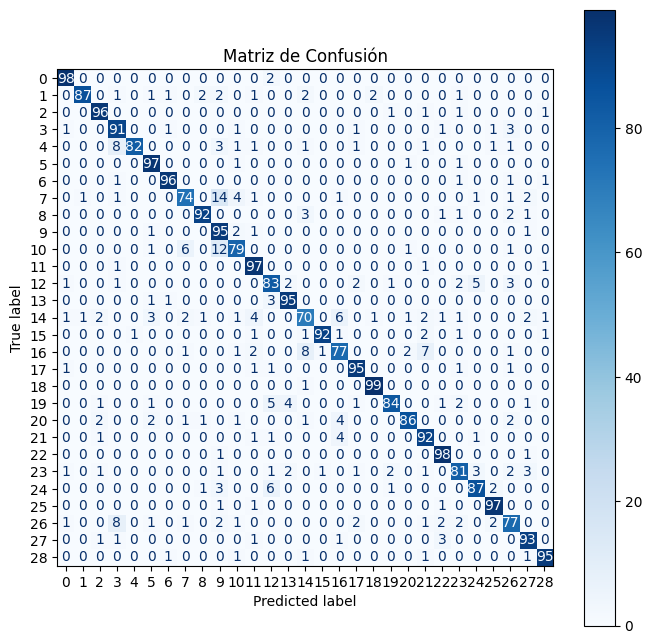

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
#load the best model
from transformers.models.vit_mae.modeling_tf_vit_mae import TFViTMAEMainLayer

# Load the best model with custom objects
# model_ = keras.models.load_model("best_modelV5.h5", custom_objects={"TFViTMAEMainLayer": TFViTMAEMainLayer})
# Obtener predicciones y etiquetas verdaderas
y_true = []
y_pred = []

for images, labels in final_val_dataset:
    predictions = model_for_inference.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))
# elmina la etiqueta 3
# y_true = [label for label in y_true if label != 3]
# y_pred = [pred for pred, label in zip(y_pred, y_true) if label != 3]
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy de validación: {accuracy:.2f}")
# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(29))  # Ajusta el rango según tus clases
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title("Matriz de Confusión")
plt.show()

1/1 [==============================] - 0s 54ms/step


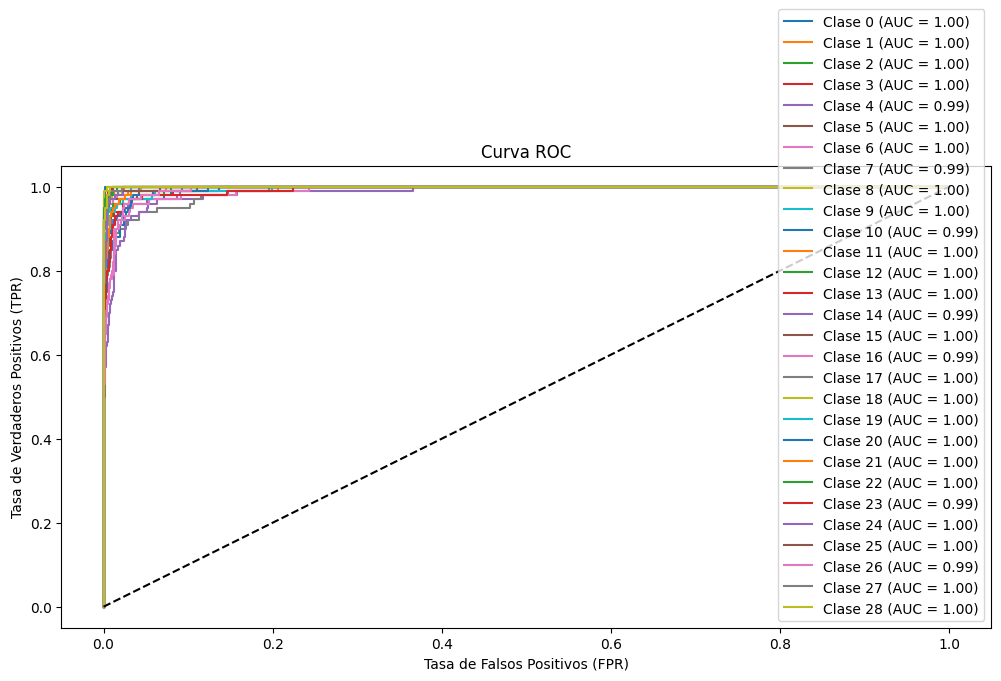

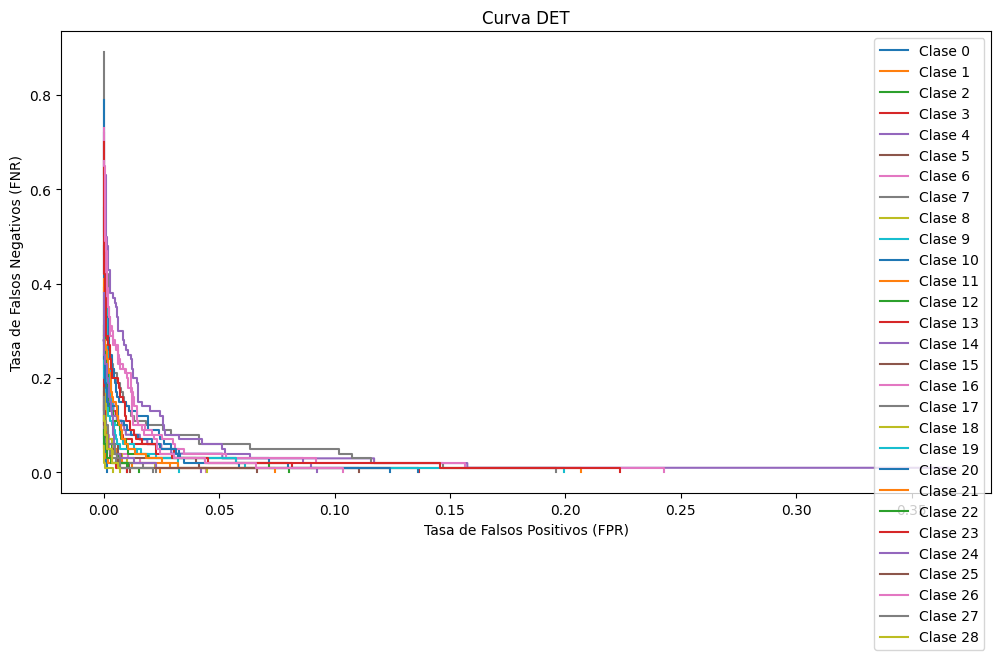

In [13]:
from sklearn.metrics import roc_curve, det_curve, auc

import matplotlib.pyplot as plt

# Convertir y_true y y_pred a formato binario para cada clase
y_true = []
y_pred = []

for images, labels in final_val_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(predictions)

y_true_binary = keras.utils.to_categorical(y_true, num_classes=29)
y_pred_binary = np.array(y_pred)

# Generar la curva ROC y calcular el AUC para cada clase
plt.figure(figsize=(12, 6))
for i in range(29):
    fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_pred_binary[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.show()

# Generar la curva DET para cada clase
plt.figure(figsize=(12, 6))
for i in range(29):
    # Verificar si hay más de una clase en y_true_binary[:, i]
    if len(np.unique(y_true_binary[:, i])) > 1:
        fpr, fnr, _ = det_curve(y_true_binary[:, i], y_pred_binary[:, i])
        plt.plot(fpr, fnr, label=f'Clase {i}')
    else:
        print(f"Clase {i} tiene solo una clase en y_true. No se puede generar la curva DET.")

plt.title('Curva DET')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Falsos Negativos (FNR)')
plt.legend(loc='upper right')
plt.show()